# Feature transformation with Amazon SageMaker processing job and Feature Store

### Introduction

In this lab you will start with the raw [Women's Clothing Reviews](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) dataset and prepare it to train a BERT-based natural language processing (NLP) model. The model will be used to classify customer reviews into positive (1), neutral (0) and negative (-1) sentiment.

You will convert the original review text into machine-readable features used by BERT. To perform the required feature transformation you will configure an Amazon SageMaker processing job, which will be running a custom Python script.

### Table of Contents

- [1. Configure the SageMaker Feature Store](#c2w1-1.)
  - [1.1. Configure dataset](#c2w1-1.1.)
  - [1.2. Configure the SageMaker feature store](#c2w1-1.2.)
    - [Exercise 1](#c2w1-ex-1)
- [2. Transform the dataset](#c2w1-2.)
    - [Exercise 2](#c2w1-ex-2)
    - [Exercise 3](#c2w1-ex-3)
- [3. Query the Feature Store](#c2w1-3.)
  - [3.1. Export training, validation, and test datasets from the Feature Store](#c2w1-3.1.)
    - [Exercise 4](#c2w1-ex-4)
  - [3.2. Export TSV from Feature Store](#c2w1-3.2.)
  - [3.3. Check that the dataset in the Feature Store is balanced by sentiment](#c2w1-3.3.)
    - [Exercise 5](#c2w1-ex-5)
    - [Exercise 6](#c2w1-ex-6)
    - [Exercise 7](#c2w1-ex-7)



In [62]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker
!conda install -q -y pytorch==1.6.0 -c pytorch
!pip install --disable-pip-version-check -q transformers==3.5.1

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


In [63]:
import boto3
import sagemaker
import botocore

config = botocore.config.Config(user_agent_extra='dlai-pds/c2/w1')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

featurestore_runtime = boto3.client(service_name='sagemaker-featurestore-runtime', 
                                    config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_featurestore_runtime_client=featurestore_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

<a name='c2w1-1.'></a>
# 1. Configure the SageMaker Feature Store

<a name='c2w1-1.1.'></a>
### 1.1. Configure dataset
The raw dataset is in the public S3 bucket. Let's start by specifying the S3 location of it:

In [64]:
raw_input_data_s3_uri = 's3://dlai-practical-data-science/data/raw/'
print(raw_input_data_s3_uri)

s3://dlai-practical-data-science/data/raw/


List the files in the S3 bucket (in this case it will be just one file):

In [65]:
!aws s3 ls $raw_input_data_s3_uri

2021-04-30 02:21:06    8457214 womens_clothing_ecommerce_reviews.csv


<a name='c2w1-1.2.'></a>
### 1.2. Configure the SageMaker feature store

As the result of the transformation, in addition to generating files in S3 bucket, you will also save the transformed data in the **Amazon SageMaker Feature Store** to be used by others in your organization, for example. 

To configure a Feature Store you need to setup a **Feature Group**. This is the main resource containing all of the metadata related to the data stored in the Feature Store. A Feature Group should contain a list of **Feature Definitions**. A Feature Definition consists of a name and the data type. The Feature Group also contains an online store configuration and an offline store configuration controlling where the data is stored. Enabling the online store allows quick access to the latest value for a record via the [GetRecord API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_feature_store_GetRecord.html). The offline store allows storage of the data in your S3 bucket. You will be using the offline store in this lab.

Let's setup the Feature Group name and the Feature Store offline prefix in S3 bucket (you will use those later in the lab):

In [66]:
import time
timestamp = int(time.time())

feature_group_name = 'reviews-feature-group-' + str(timestamp)
feature_store_offline_prefix = 'reviews-feature-store-' + str(timestamp)

print('Feature group name: {}'.format(feature_group_name))
print('Feature store offline prefix in S3: {}'.format(feature_store_offline_prefix))

Feature group name: reviews-feature-group-1685406380
Feature store offline prefix in S3: reviews-feature-store-1685406380


Taking two features from the original raw dataset (`Review Text` and `Rating`), you will transform it preparing to be used for the model training and then to be saved in the Feature Store. Here you will define the related features to be stored as a list of `FeatureDefinition`.

In [67]:
from sagemaker.feature_store.feature_definition import (
    FeatureDefinition,
    FeatureTypeEnum,
)

feature_definitions= [
    # unique ID of the review
    FeatureDefinition(feature_name='review_id', feature_type=FeatureTypeEnum.STRING), 
    # ingestion timestamp
    FeatureDefinition(feature_name='date', feature_type=FeatureTypeEnum.STRING),
    # sentiment: -1 (negative), 0 (neutral) or 1 (positive). It will be found the Rating values (1, 2, 3, 4, 5)
    FeatureDefinition(feature_name='sentiment', feature_type=FeatureTypeEnum.STRING), 
    # label ID of the target class (sentiment)
    FeatureDefinition(feature_name='label_id', feature_type=FeatureTypeEnum.STRING),
    # reviews encoded with the BERT tokenizer
    FeatureDefinition(feature_name='input_ids', feature_type=FeatureTypeEnum.STRING),
    # original Review Text
    FeatureDefinition(feature_name='review_body', feature_type=FeatureTypeEnum.STRING),
    # train/validation/test label
    FeatureDefinition(feature_name='split_type', feature_type=FeatureTypeEnum.STRING)
]

<a name='c2w1-ex-1'></a>
### Exercise 1

Create the feature group using the feature definitions defined above.

**Instructions:** Use the `FeatureGroup` function passing the defined above feature group name and the feature definitions.

```python
feature_group = FeatureGroup(
    name=..., # Feature Group name
    feature_definitions=..., # a list of Feature Definitions
    sagemaker_session=sess # SageMaker session
)
```

In [68]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    name=feature_group_name, # Replace None
    feature_definitions=feature_definitions, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    sagemaker_session=sess
)

print(feature_group)

FeatureGroup(name='reviews-feature-group-1685406380', sagemaker_session=<sagemaker.session.Session object at 0x7fcd0284af90>, feature_definitions=[FeatureDefinition(feature_name='review_id', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='date', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='sentiment', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='label_id', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='review_body', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='split_type', feature_type=<FeatureTypeEnum.STRING: 'String'>)])


You will use the defined Feature Group later in this lab, the actual creation of the Feature Group will take place in the processing job. Now let's move into the setup of the processing job to transform the dataset.

<a name='c2w1-2.'></a>
# 2. Transform the dataset

You will configure a SageMaker processing job to run a custom Python script to balance and transform the raw data into a format used by BERT model.

Set the transformation parameters including the instance type, instance count, and train/validation/test split percentages. For the purposes of this lab, you will use a relatively small instance type. Please refer to [this](https://aws.amazon.com/sagemaker/pricing/) link for additional instance types that may work for your use case outside of this lab.

You can also choose whether you want to balance the dataset or not. In this case, you will balance the dataset to avoid class imbalance in the target variable, `sentiment`. 

Another important parameter of the model is the `max_seq_length`, which specifies the maximum length of the classified reviews for the RoBERTa model. If the sentence is shorter than the maximum length parameter, it will be padded. In another case, when the sentence is longer, it will be truncated from the right side.

Since a smaller `max_seq_length` leads to faster training and lower resource utilization, you want to find the smallest power-of-2 that captures `100%` of our reviews.  For this dataset, the `100th` percentile is `115`.  However, it's best to stick with powers-of-2 when using BERT. So let's choose `128` as this is the smallest power-of-2 greater than `115`. You will see below how the shorter sentences will be padded to a maximum length.


```
mean        52.512374
std         31.387048
min          1.000000
10%         10.000000
20%         22.000000
30%         32.000000
40%         41.000000
50%         51.000000
60%         61.000000
70%         73.000000
80%         88.000000
90%         97.000000
100%       115.000000
max        115.000000
```

![](images/distribution_num_words_per_review.png)


In [69]:
processing_instance_type='ml.c5.xlarge'
processing_instance_count=1
train_split_percentage=0.90
validation_split_percentage=0.05
test_split_percentage=0.05
balance_dataset=True
max_seq_length=128

To balance and transform our data, you will use a scikit-learn-based processing job. This is essentially a generic Python processing job with scikit-learn pre-installed. You can specify the version of scikit-learn you wish to use. Also pass the SageMaker execution role, processing instance type and instance count.

In [70]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    framework_version='0.23-1',
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={'AWS_DEFAULT_REGION': region},                             
    max_runtime_in_seconds=7200
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


The processing job will be running the Python code from the file `src/prepare_data.py`. In the following exercise you will review the contents of the file and familiarize yourself with main parts of it. 

<a name='c2w1-ex-2'></a>
### Exercise 2

1. Open the file [src/prepare_data.py](src/prepare_data.py). Go through the comments to understand its content.
2. Find and review the `convert_to_bert_input_ids()` function, which contains the RoBERTa `tokenizer` configuration.
3. Complete method `encode_plus` of the RoBERTa `tokenizer`. Pass the `max_seq_length` as a value for the argument `max_length`. It defines a pad to a maximum length specified.
4. Save the file [src/prepare_data.py](src/prepare_data.py) (with the menu command File -> Save Python File).

### _This cell will take approximately 1-2 minutes to run._

In [71]:
import sys, importlib
sys.path.append('src/')

# import the `prepare_data.py` module
import prepare_data

# reload the module if it has been previously loaded 
if 'prepare_data' in sys.modules:
    importlib.reload(prepare_data)

input_ids = prepare_data.convert_to_bert_input_ids("this product is great!", max_seq_length)
    
updated_correctly = False

if len(input_ids) != max_seq_length:
    print('#######################################################################################################')
    print('Please check that the function \'convert_to_bert_input_ids\' in the file src/prepare_data.py is complete.')
    print('#######################################################################################################')
    raise Exception('Please check that the function \'convert_to_bert_input_ids\' in the file src/prepare_data.py is complete.')
else:
    print('##################')
    print('Updated correctly!')
    print('##################')

    updated_correctly = True

##################
Updated correctly!
##################


Review the results of tokenization for the given example (*\"this product is great!\"*):

In [72]:
input_ids = prepare_data.convert_to_bert_input_ids("this product is great!", max_seq_length)

print(input_ids)
print('Length of the sequence: {}'.format(len(input_ids)))

[0, 9226, 1152, 16, 372, 328, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Length of the sequence: 128


Launch the processing job with the custom script passing defined above parameters.

In [73]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

if (updated_correctly):

    processor.run(code='src/prepare_data.py',
              inputs=[
                    ProcessingInput(source=raw_input_data_s3_uri,
                                    destination='/opt/ml/processing/input/data/',
                                    s3_data_distribution_type='ShardedByS3Key')
              ],
              outputs=[
                    ProcessingOutput(output_name='sentiment-train',
                                     source='/opt/ml/processing/output/sentiment/train',
                                     s3_upload_mode='EndOfJob'),
                    ProcessingOutput(output_name='sentiment-validation',
                                     source='/opt/ml/processing/output/sentiment/validation',
                                     s3_upload_mode='EndOfJob'),
                    ProcessingOutput(output_name='sentiment-test',
                                     source='/opt/ml/processing/output/sentiment/test',
                                     s3_upload_mode='EndOfJob')
              ],
              arguments=['--train-split-percentage', str(train_split_percentage),
                         '--validation-split-percentage', str(validation_split_percentage),
                         '--test-split-percentage', str(test_split_percentage),
                         '--balance-dataset', str(balance_dataset),
                         '--max-seq-length', str(max_seq_length),                         
                         '--feature-store-offline-prefix', str(feature_store_offline_prefix),
                         '--feature-group-name', str(feature_group_name)                         
              ],
              logs=True,
              wait=False)

else:
    print('#######################################')
    print('Please update the code correctly above.')
    print('#######################################')    

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2023-05-30-00-26-54-331


You can see the information about the processing jobs using the `describe` function. The result is in dictionary format. Let's pull the processing job name:

In [74]:
scikit_processing_job_name = processor.jobs[-1].describe()['ProcessingJobName']

print('Processing job name: {}'.format(scikit_processing_job_name))

Processing job name: sagemaker-scikit-learn-2023-05-30-00-26-54-331


<a name='c2w1-ex-3'></a>
### Exercise 3

Pull the processing job status from the processing job description.

**Instructions**: Print the keys of the processing job description dictionary, choose the one related to the status of the processing job and print the value of it.

In [75]:
print(processor.jobs[-1].describe().keys())

dict_keys(['ProcessingInputs', 'ProcessingOutputConfig', 'ProcessingJobName', 'ProcessingResources', 'StoppingCondition', 'AppSpecification', 'Environment', 'RoleArn', 'ProcessingJobArn', 'ProcessingJobStatus', 'LastModifiedTime', 'CreationTime', 'ResponseMetadata'])


In [84]:
### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
scikit_processing_job_status = processor.jobs[-1].describe()["ProcessingJobStatus"] # Replace None
### END SOLUTION - DO NOT delete this comment for grading purposes
print('Processing job status: {}'.format(scikit_processing_job_status))

Processing job status: Completed


Review the created processing job in the AWS console.

**Instructions**: 
- open the link
- notice that you are in the section `Amazon SageMaker` -> `Processing jobs`
- check the name of the processing job, its status and other available information

In [81]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, scikit_processing_job_name)))

Wait for about 5 minutes to review the CloudWatch Logs. You may open the file [src/prepare_data.py](src/prepare_data.py) again and examine the outputs of the code in the CloudWatch logs.

In [82]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, scikit_processing_job_name)))

After the completion of the processing job you can also review the output in the S3 bucket.

In [83]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 output data</a> after the processing job has completed</b>'.format(bucket, scikit_processing_job_name, region)))


Wait for the processing job to complete.

### _This cell will take approximately 15 minutes to run._

In [85]:
%%time

running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=scikit_processing_job_name,
    sagemaker_session=sess
)

running_processor.wait(logs=False)

!CPU times: user 17.6 ms, sys: 3.35 ms, total: 21 ms
Wall time: 5.14 s


_Please wait until ^^ Processing Job ^^ completes above_

Inspect the transformed and balanced data in the S3 bucket.

In [90]:
processing_job_description = running_processor.describe()

output_config = processing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    if output['OutputName'] == 'sentiment-train':
        processed_train_data_s3_uri = output['S3Output']['S3Uri']
    if output['OutputName'] == 'sentiment-validation':
        processed_validation_data_s3_uri = output['S3Output']['S3Uri']
    if output['OutputName'] == 'sentiment-test':
        processed_test_data_s3_uri = output['S3Output']['S3Uri']
        
print(processed_train_data_s3_uri)
print(processed_validation_data_s3_uri)
print(processed_test_data_s3_uri)

s3://sagemaker-us-east-1-608521957199/sagemaker-scikit-learn-2023-05-30-00-26-54-331/output/sentiment-train
s3://sagemaker-us-east-1-608521957199/sagemaker-scikit-learn-2023-05-30-00-26-54-331/output/sentiment-validation
s3://sagemaker-us-east-1-608521957199/sagemaker-scikit-learn-2023-05-30-00-26-54-331/output/sentiment-test


In [91]:
!aws s3 ls $processed_train_data_s3_uri/

2023-05-30 00:40:12    4892652 part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [92]:
!aws s3 ls $processed_validation_data_s3_uri/

2023-05-30 00:40:12     273158 part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [93]:
!aws s3 ls $processed_test_data_s3_uri/

2023-05-30 00:40:13     268184 part-algo-1-womens_clothing_ecommerce_reviews.tsv


Copy the data into the folder `balanced`.

In [94]:
!aws s3 cp $processed_train_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./balanced/sentiment-train/
!aws s3 cp $processed_validation_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./balanced/sentiment-validation/
!aws s3 cp $processed_test_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./balanced/sentiment-test/

download: s3://sagemaker-us-east-1-608521957199/sagemaker-scikit-learn-2023-05-30-00-26-54-331/output/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv to balanced/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv
download: s3://sagemaker-us-east-1-608521957199/sagemaker-scikit-learn-2023-05-30-00-26-54-331/output/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv to balanced/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv
download: s3://sagemaker-us-east-1-608521957199/sagemaker-scikit-learn-2023-05-30-00-26-54-331/output/sentiment-test/part-algo-1-womens_clothing_ecommerce_reviews.tsv to balanced/sentiment-test/part-algo-1-womens_clothing_ecommerce_reviews.tsv


Review the training, validation and test data outputs:

In [95]:
!head -n 5 ./balanced/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv

review_id	sentiment	label_id	input_ids	review_body	date
7265	-1	0	[0, 16861, 42, 299, 16, 6399, 12, 16096, 1437, 8, 939, 437, 129, 195, 108, 306, 845, 782, 7, 28, 59, 231, 113, 1181, 4, 156, 9, 22861, 28517, 1468, 1437, 61, 939, 1979, 75, 1508, 114, 24, 58, 1181, 4, 67, 1237, 182, 1810, 12, 2740, 41, 3023, 29, 8, 115, 33, 1613, 2735, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	"Unfortunately this top is shirt-length  and i'm only 5'4"". needs to be about 6"" longer. made of sweatshirt material  which i wouldn't mind if it were longer. also runs very wide- ordered an xs and could have gone smaller."	2023-05-30T00:34:27Z
4166	-1	0	[0, 100, 802, 42, 74, 28, 10, 11962, 265, 23048, 16576, 4, 939, 4157, 7, 224, 24, 1437, 53, 939, 1299, 101, 24, 29139, 66, 25, 114, 939, 58, 524, 30922, 3267, 30922, 50, 103, 8401, 32753, 

In [96]:
!head -n 5 ./balanced/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv

review_id	sentiment	label_id	input_ids	review_body	date
1093	-1	0	[0, 100, 437, 98, 5784, 5779, 4, 5, 3588, 16, 2721, 53, 5, 65, 939, 829, 16, 9007, 8, 34, 1533, 33940, 9, 35036, 1716, 4, 2129, 1318, 797, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	I'm so incredibly disappointed. the dress is beautiful but the one i received is torn and has multiple strands of beads missing. poor quality control.	2023-05-30T00:34:27Z
8425	1	2	[0, 713, 16, 5, 1969, 6013, 4, 24, 18, 2422, 3793, 1437, 372, 8089, 8, 19, 10, 3989, 14, 2386, 47, 7, 3568, 10, 1675, 11689, 4, 275, 9, 70, 1437, 24, 21, 1661, 11, 4716, 405, 324, 10070, 4, 13, 162, 14, 839, 939, 1747, 33, 10, 6013, 14, 630, 75, 4044, 23, 5, 3701, 50, 15500, 350, 614, 50, 5005, 162, 19, 7400, 5933, 

In [97]:
!head -n 5 ./balanced/sentiment-test/part-algo-1-womens_clothing_ecommerce_reviews.tsv

review_id	sentiment	label_id	input_ids	review_body	date
5579	0	1	[0, 100, 1705, 75, 679, 141, 1769, 42, 3588, 1088, 66, 77, 51, 58, 519, 5, 1136, 6174, 131, 51, 56, 95, 342, 24, 15, 5, 998, 8, 24, 1088, 66, 11, 127, 1836, 11, 10, 948, 9, 722, 328, 1437, 939, 95, 829, 5, 3588, 452, 8, 269, 101, 5, 7708, 1571, 9, 24, 4, 1437, 47, 64, 2773, 3588, 24, 62, 50, 159, 8, 24, 202, 1326, 79, 1951, 1169, 169, 4, 1437, 99, 939, 399, 75, 101, 59, 5, 3588, 21, 14, 5, 1468, 16, 10, 410, 2342, 38755, 1118, 7, 141, 24, 1326, 11, 5, 2170, 4, 1437, 939, 524, 15, 5, 8146, 2624, 114, 939, 40, 489, 24, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	I couldn't believe how fast this dress sold out when they were having the fall promotion; they had just put it on the website and it sold out in my size in a matter of hours!  i just received the dress today and really like the practicality of it.  you can easily dress it up or down and it still looks sheek either way.  what i didn't like about the dress was that t

<a name='c2w1-3.'></a>
# 3. Query the Feature Store
In addition to transforming the data and saving in S3 bucket, the processing job populates the feature store with the transformed and balanced data.  Let's query this data using Amazon Athena.

<a name='c2w1-3.1.'></a>
### 3.1. Export training, validation, and test datasets from the Feature Store

Here you will do the export only for the training dataset, as an example. 

Use `athena_query()` function to create an Athena query for the defined above Feature Group. Then you can pull the table name of the Amazon Glue Data Catalog table which is auto-generated by Feature Store.

In [99]:
feature_store_query = feature_group.athena_query()

feature_store_table = feature_store_query.table_name

query_string = """
    SELECT date,
        review_id,
        sentiment, 
        label_id,
        input_ids,
        review_body
    FROM "{}" 
    WHERE split_type='train' 
    LIMIT 5
""".format(feature_store_table)

print('Glue Catalog table name: {}'.format(feature_store_table))
print('Running query: {}'.format(query_string))

Glue Catalog table name: reviews_feature_group_1685406380_1685406805
Running query: 
    SELECT date,
        review_id,
        sentiment, 
        label_id,
        input_ids,
        review_body
    FROM "reviews_feature_group_1685406380_1685406805" 
    WHERE split_type='train' 
    LIMIT 5



Configure the S3 location for the query results.  This allows us to re-use the query results for future queries if the data has not changed.  We can even share this S3 location between team members to improve query performance for common queries on data that does not change often.

In [100]:
output_s3_uri = 's3://{}/query_results/{}/'.format(bucket, feature_store_offline_prefix)
print(output_s3_uri)

s3://sagemaker-us-east-1-608521957199/query_results/reviews-feature-store-1685406380/


<a name='c2w1-ex-4'></a>
### Exercise 4

Query the feature store.

**Instructions**: Use `feature_store_query.run` function passing the constructed above query string and the location of the output S3 bucket.

```python
feature_store_query.run(
    query_string=..., # query string
    output_location=... # location of the output S3 bucket
)
```

In [101]:
feature_store_query.run(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    query_string=query_string, # Replace None
    output_location=output_s3_uri # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
)

feature_store_query.wait()

INFO:sagemaker:Query c84a4d54-e2a4-4b5b-bf8f-490332253eaf is being executed.
INFO:sagemaker:Query c84a4d54-e2a4-4b5b-bf8f-490332253eaf successfully executed.


In [102]:
import pandas as pd
pd.set_option("max_colwidth", 100)

df_feature_store = feature_store_query.as_dataframe()
df_feature_store

,date,review_id,sentiment,label_id,input_ids,review_body
0,2023-05-30T00:34:27Z,88,-1,0,"[0, 133, 1521, 73, 43882, 9, 5, 3588, 32, 1341, 34203, 1437, 2342, 32430, 8, 27360, 4, 53, 17220...",The design/shape of the dress are quite flattering flirty and feminine. but.... there is no way...
1,2023-05-30T00:34:27Z,11471,-1,0,"[0, 713, 299, 16, 269, 2721, 1437, 53, 1326, 3668, 11385, 15, 127, 195, 108, 466, 113, 15162, 14...","This top is really beautiful but looks absolutely horrible on my 5'9"" apple shaped body. in the..."
2,2023-05-30T00:34:27Z,3601,1,2,"[0, 100, 1747, 11224, 128, 2977, 108, 15, 5, 8978, 3588, 148, 5, 983, 1392, 4, 5, 3588, 16, 1435...",I finally pressed 'go' on the orange dress during the weekend sale. the dress is terrific. i am ...
3,2023-05-30T00:34:27Z,18659,1,2,"[0, 16713, 3793, 1437, 2927, 21764, 1437, 6399, 7886, 23385, 8, 1457, 1690, 17670, 39336, 4, 431...",Super soft cap sleeves shirt tail hem and double stitched seams. mine is the grey/green motif ...
4,2023-05-30T00:34:27Z,14174,0,1,"[0, 100, 524, 10, 1307, 25172, 23324, 2378, 4, 959, 1437, 209, 58, 1684, 739, 4, 939, 524, 45, 1...",I am a huge pilcro fan. however these were beyond large. i am not even sure that the next size ...


Review the Feature Store in SageMaker Studio

![](images/sm_studio_extensions_featurestore.png)

<a name='c2w1-3.2.'></a>
### 3.2. Export TSV from Feature Store

Save the output as a TSV file:

In [103]:
df_feature_store.to_csv('./feature_store_export.tsv',
                        sep='\t',
                        index=False,
                        header=True)

In [104]:
!head -n 5 ./feature_store_export.tsv

date	review_id	sentiment	label_id	input_ids	review_body
2023-05-30T00:34:27Z	88	-1	0	[0, 133, 1521, 73, 43882, 9, 5, 3588, 32, 1341, 34203, 1437, 2342, 32430, 8, 27360, 4, 53, 17220, 89, 16, 117, 169, 14, 5, 3588, 939, 829, 16, 92, 4, 5, 3195, 16, 10, 21155, 15158, 66, 1275, 8, 89, 32, 909, 36626, 70, 81, 5, 7494, 443, 4, 89, 16, 117, 6694, 734, 5, 10199, 1326, 13868, 16572, 8, 35564, 3215, 8, 16, 45, 17766, 1437, 13116, 50, 92, 4, 939, 524, 182, 5779, 30, 5, 1318, 9, 5, 6880, 14, 939, 829, 4, 14217, 42, 65, 16, 164, 124, 4, 1437, 14880, 6215, 111, 2540, 146, 686, 14, 47, 109, 45, 2142, 1198, 12, 1722, 1397, 5296, 7201, 7, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	The design/shape of the dress are quite flattering  flirty and feminine. but.... there is no way that the dress i received is new. the color is a faded washed out red and there are black stains all over the belt area. there is no tag... the fabric looks droopy and laundered and is not crisp  stiff or new. i am very disa

Upload TSV to the S3 bucket:

In [105]:
!aws s3 cp ./feature_store_export.tsv s3://$bucket/feature_store/feature_store_export.tsv

upload: ./feature_store_export.tsv to s3://sagemaker-us-east-1-608521957199/feature_store/feature_store_export.tsv


Check the file in the S3 bucket:

In [106]:
!aws s3 ls --recursive s3://$bucket/feature_store/feature_store_export.tsv

2023-05-30 00:54:50       4496 feature_store/feature_store_export.tsv


<a name='c2w1-3.3.'></a>
### 3.3. Check that the dataset in the Feature Store is balanced by sentiment

Now you can setup an Athena query to check that the stored dataset is balanced by the target class `sentiment`.

<a name='c2w1-ex-5'></a>
### Exercise 5

Write an SQL query to count the total number of the reviews per `sentiment` stored in the Feature Group.

**Instructions**: Pass the SQL statement of the form 

```sql
SELECT category_column, COUNT(*) AS new_column_name
FROM table_name
GROUP BY category_column
```

into the variable `query_string_count_by_sentiment`. Here you would need to use the column `sentiment` and give a name `count_reviews` to the new column with the counts.

In [107]:
feature_store_query_2 = feature_group.athena_query()

# Replace all None
### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
query_string_count_by_sentiment = """
SELECT sentiment, COUNT(*) AS num_sentiment
FROM "{}"
GROUP BY sentiment
""".format(feature_store_table)
### END SOLUTION - DO NOT delete this comment for grading purposes

<a name='c2w1-ex-6'></a>
### Exercise 6

Query the feature store.

**Instructions**: Use `run` function of the Feature Store query, passing the new query string `query_string_count_by_sentiment`. The output S3 bucket will remain unchanged. You can follow the example above.

In [108]:
feature_store_query_2.run(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    query_string=query_string_count_by_sentiment, # Replace None
    output_location=output_s3_uri # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
)

feature_store_query_2.wait()

df_count_by_sentiment = feature_store_query_2.as_dataframe()
df_count_by_sentiment

INFO:sagemaker:Query b295373b-8341-4ed0-ab25-d7ae159e3de5 is being executed.
INFO:sagemaker:Query b295373b-8341-4ed0-ab25-d7ae159e3de5 successfully executed.


,sentiment,num_sentiment
0,1,2051
1,-1,2051
2,0,2051


<a name='c2w1-ex-7'></a>
### Exercise 7

Visualize the result of the query in the bar plot, showing the count of the reviews by sentiment value.

**Instructions**: Pass the resulting data frame `df_count_by_sentiment` into the `barplot` function of the `seaborn` library.

```python
sns.barplot(
    data=..., 
    x='...', 
    y='...',
    color="blue"
)
```

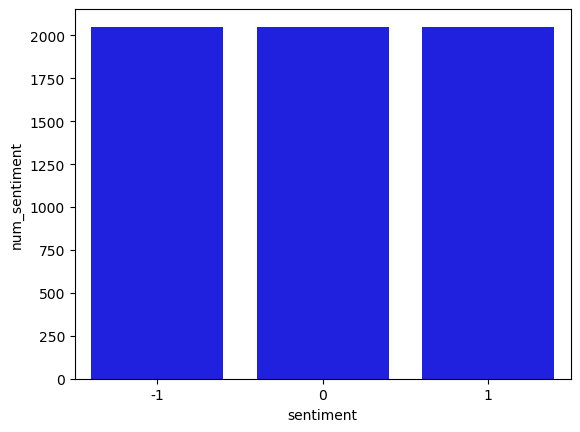

In [111]:
%matplotlib inline
import seaborn as sns

sns.barplot(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    data=df_count_by_sentiment, # Replace None
    x="sentiment", # Replace None
    y="num_sentiment", # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    color="blue"
)

Upload the notebook and `prepare_data.py` file into S3 bucket for grading purposes.

**Note**: you may need to save the file before the upload.

In [112]:
!aws s3 cp ./C2_W1_Assignment.ipynb s3://$bucket/C2_W1_Assignment_Learner.ipynb
!aws s3 cp ./src/prepare_data.py s3://$bucket/src/C2_W1_prepare_data_Learner.py

upload: ./C2_W1_Assignment.ipynb to s3://sagemaker-us-east-1-608521957199/C2_W1_Assignment_Learner.ipynb
upload: src/prepare_data.py to s3://sagemaker-us-east-1-608521957199/src/C2_W1_prepare_data_Learner.py


Please go to the main lab window and click on `Submit` button (see the `Finish the lab` section of the instructions).